In [1]:
import os, glob, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("TensorFlow:", tf.__version__)

TensorFlow: 2.10.1


# Cell 1 – Tạo bộ dữ liệu chuẩn flow_from_directory

In [2]:
DATA_DIR  = r"C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2"
train_dir = os.path.join(DATA_DIR, "train")
val_dir   = os.path.join(DATA_DIR, "val")
test_dir  = os.path.join(DATA_DIR, "test")

CLASSES = ["NORMAL", "PNEUMONIA_bacteria", "PNEUMONIA_virus"]

# model tác giả: input 150x150x1
IMG_SIZE = (150, 150)
CHANNELS = 1
BATCH    = 32

CKPT_DIR = os.path.join(DATA_DIR, "checkpoints_cnn_author")
os.makedirs(CKPT_DIR, exist_ok=True)

# Cell 2 – Data generator

2.1 Cấu hình ImageDataGenerator

In [31]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

val_test_gen = ImageDataGenerator(rescale=1./255)

2.2 Tạo generator train / val / test

In [32]:
train_gen = train_aug.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    classes=CLASSES,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH,
    color_mode="grayscale"  # 1 kênh để khớp model tác giả
)
val_gen = val_test_gen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    classes=CLASSES,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
    color_mode="grayscale"
)
test_gen = val_test_gen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    classes=CLASSES,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
    color_mode="grayscale"
)

idx2class = {v:k for k, v in train_gen.class_indices.items()}
print("Mapping class indices:", idx2class)

Found 9097 images belonging to 3 classes.
Found 1359 images belonging to 3 classes.
Found 1355 images belonging to 3 classes.
Mapping class indices: {0: 'NORMAL', 1: 'PNEUMONIA_bacteria', 2: 'PNEUMONIA_virus'}


# Cell 3 – Mô hình CNN mẫu của tác giả

3.1 — Khai báo kiến trúc

In [33]:
def build_author_cnn(input_shape=(150,150,1), n_classes=3):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')  # <— 3 nhãn
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

3.2 — Compile & summary

In [34]:
model = build_author_cnn(IMG_SIZE + (CHANNELS,), n_classes=len(CLASSES))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

# Cell 4 – Train 50 epochs + callback + checkpoint

In [ ]:
# Callbacks & cấu hình bước
EPOCHS = 50
steps_per_epoch = max(1, math.ceil(train_gen.samples / BATCH))
val_steps       = max(1, math.ceil(val_gen.samples   / BATCH))


ckpt_path = os.path.join(CKPT_DIR, "author_cnn_3cls_best.h5")
callbacks = [
    ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
]
#Fit
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=val_steps,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
285/285 [==============================] - ETA: 0s - loss: 0.7971 - accuracy: 0.6205
Epoch 1: val_accuracy improved from -inf to 0.76306, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\checkpoints_cnn_author\author_cnn_3cls_best.h5
285/285 [==============================] - 227s 794ms/step - loss: 0.7971 - accuracy: 0.6205 - val_loss: 0.5349 - val_accuracy: 0.7631 - lr: 0.0010
Epoch 2/50
285/285 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.7069
Epoch 2: val_accuracy improved from 0.76306 to 0.77778, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\checkpoints_cnn_author\author_cnn_3cls_best.h5
285/285 [==============================] - 81s 282ms/step - loss: 0.6470 - accuracy: 0.7069 - val_loss: 0.5005 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 3/50
285/285 [==============================] - ETA: 0s - loss: 0.5939 - accuracy: 0.7368
Epoch 3: val_accuracy improved from 0.77778 to 0.78514, saving model

# Cell 5. Đánh giá & báo cáo

5.1 Evaluate trên test

In [35]:
test_steps = math.ceil(test_gen.samples / BATCH)
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | loss: {test_loss:.4f}")

Test accuracy: 0.3210 | loss: 1.0987


5.2 Lấy y_true / y_pred / prob

In [ ]:
test_gen.reset()
pred_prob = model.predict(test_gen, steps=test_steps, verbose=0)
y_pred = np.argmax(pred_prob, axis=1)
y_true = test_gen.classes

5.3 — Classification report

In [37]:
print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))

                    precision    recall  f1-score   support

            NORMAL     1.0000    0.0022    0.0044       455
PNEUMONIA_bacteria     0.2664    0.3600    0.3062       450
   PNEUMONIA_virus     0.3646    0.6044    0.4548       450

          accuracy                         0.3210      1355
         macro avg     0.5437    0.3222    0.2552      1355
      weighted avg     0.5454    0.3210    0.2542      1355



5.4 Vẽ Confusion Matrix 

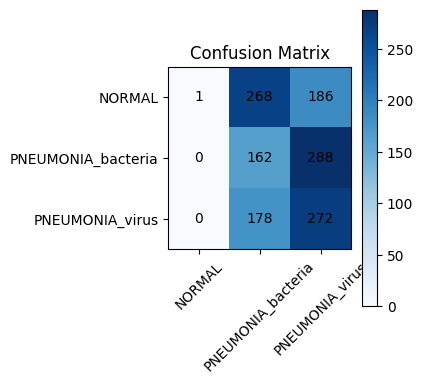

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4.2,4.2))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xticks(range(len(CLASSES)), CLASSES, rotation=45)
plt.yticks(range(len(CLASSES)), CLASSES)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar()
plt.tight_layout(); plt.show()


5.5 Learning curves từ history

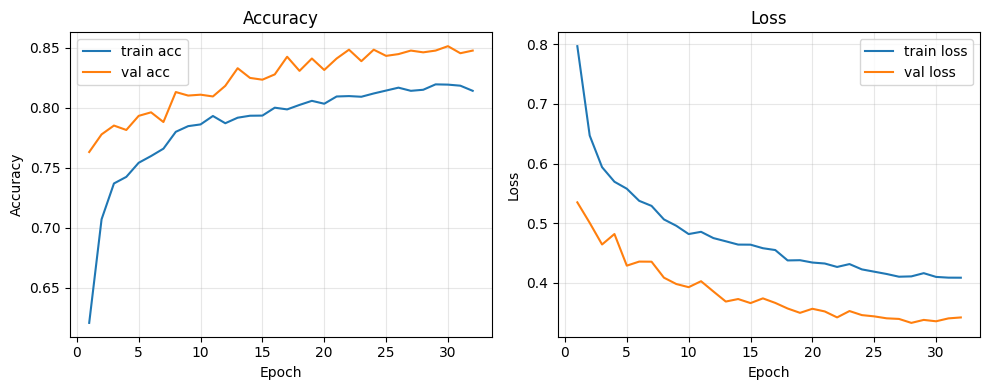

In [40]:
h = history.history

epochs = range(1, len(h["loss"])+1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, h["accuracy"], label="train acc")
plt.plot(epochs, h["val_accuracy"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy")
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(epochs, h["loss"], label="train loss")
plt.plot(epochs, h["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss")
plt.legend(); plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Test nhanh vài ảnh

6.1 Hàm predict_one (grayscale 150×150, đúng pipeline rescale 1/255)

In [15]:
def predict_one(img_path, model, target_size=(150,150)):
    # đọc grayscale cho đúng kiến trúc tác giả
    img0 = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size, color_mode="grayscale")
    x = tf.keras.preprocessing.image.img_to_array(img0) / 1.0  # giữ nguyên 0..255 vì sẽ rescale giống gen?
    x = x / 255.0                                              # chuẩn hóa 0..1 giống generator
    x = np.expand_dims(x, 0)                                   # (1,H,W,1)

    prob = model.predict(x, verbose=0)[0]
    idx  = int(np.argmax(prob))
    return CLASSES[idx], float(prob[idx]), img0

6.2 — Lấy ngẫu nhiên 6 ảnh từ test/

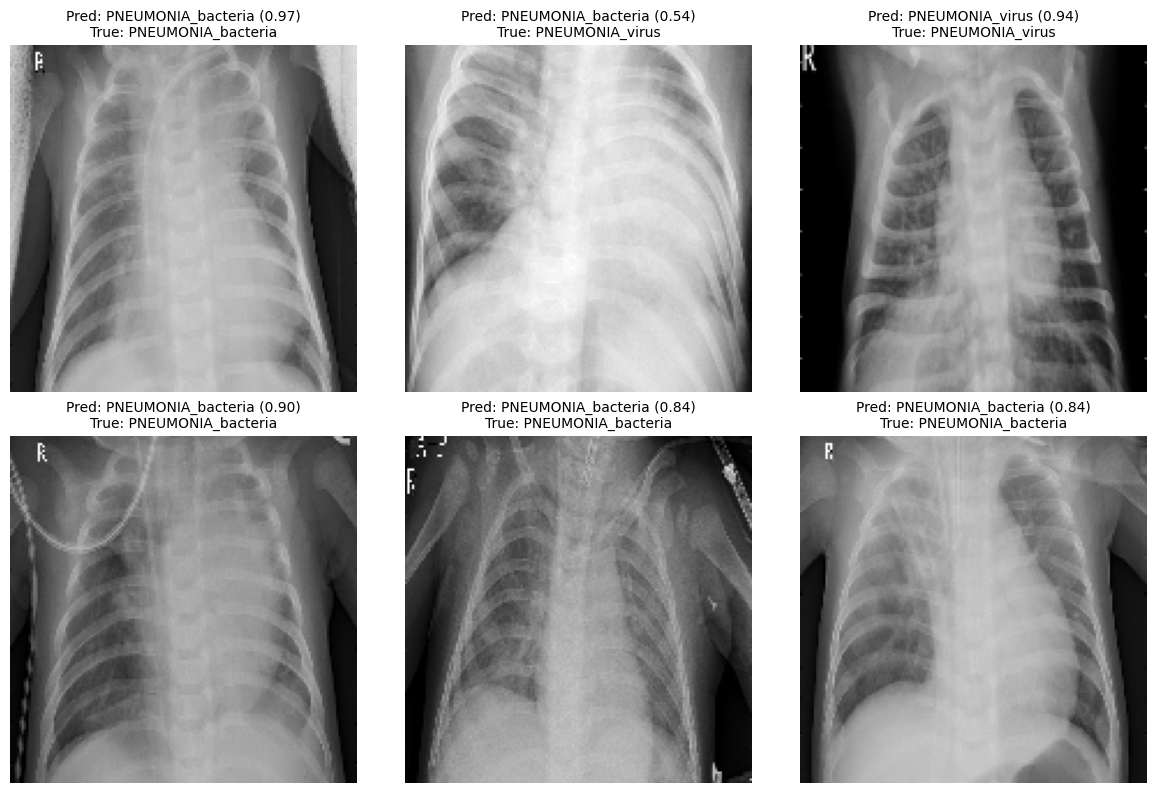

In [ ]:
samples = []
for c in CLASSES:
    samples += glob.glob(os.path.join(test_dir, c, "*"))
random.shuffle(samples)
samples = samples[:6]

cols = 3
rows = (len(samples)+cols-1)//cols
plt.figure(figsize=(12, 4*rows))

for i, p in enumerate(samples, 1):
    pred_lbl, pred_conf, pil_img = predict_one(p, model, target_size=IMG_SIZE)
    true_lbl = os.path.basename(os.path.dirname(p))

    plt.subplot(rows, cols, i)
    plt.imshow(pil_img, cmap="gray")
    title = f"Pred: {pred_lbl} ({pred_conf:.2f})\nTrue: {true_lbl}"
    plt.title(title, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

# 7.Vẽ Grad-CAM cho ảnh

7.1  Tìm lớp conv cuối

In [10]:
def pick_last_conv_layer(model):
    for layer in reversed(model.layers):
        try:
            shape = layer.output_shape
        except:
            continue
        # Lớp có 4 chiều => feature map
        if isinstance(shape, tuple) and len(shape) == 4:
            return layer.name
    raise ValueError("Không tìm thấy lớp convolution 4D cuối.")

7.2 Tạo heatmap

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_name, class_index=None):
    #  Tạo model phụ đầu ra gồm (feature map cuối, output softmax)
    last_conv = model.get_layer(last_conv_name)
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [last_conv.output, model.output])
    #  Dùng GradientTape để tính đạo hàm của dự đoán theo feature map
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        if class_index is None:
            class_index = tf.argmax(predictions[0])  # lớp dự đoán cao nhất
        class_channel = predictions[:, class_index]  # y_pred của lớp đó
    # Tính gradient 
    grads = tape.gradient(class_channel, conv_outputs)
   # Tính “trọng số kênh” = trung bình gradient trên mỗi kênh
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    #  Tính tổ hợp tuyến tính: sum_k(α_k * A_k)
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    # Chuẩn hóa về [0, 1] 
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


7.3 Hiển thị 1 ảnh (trái gốc | phải Grad-CAM)

In [12]:
def show_gradcam_pair(img_path, model, target_size=(150,150)):
    img0 = tf.keras.preprocessing.image.load_img(
        img_path, target_size=target_size, color_mode='grayscale')
    x = tf.keras.preprocessing.image.img_to_array(img0) / 255.0  # (H,W,1)
    x = np.expand_dims(x, axis=0)                                # (1,H,W,1)

    # 2Dự đoán xác suất từng lớp
    preds = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(preds))
    pred_label = CLASSES[pred_idx]
    pred_prob  = float(preds[pred_idx])

    # Lấy lớp conv cuối + tạo heatmap
    last_conv_name = pick_last_conv_layer(model)
    heatmap = make_gradcam_heatmap(x, model, last_conv_name, class_index=pred_idx)

    # Chuyển heatmap sang màu (JET colormap)
    heatmap = cv2.resize(heatmap, target_size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Chuyển ảnh gốc 1 kênh → 3 kênh để overlay
    img_gray = np.uint8(np.clip(x[0]*255.0, 0, 255))
    img_rgb  = np.repeat(img_gray, 3, axis=2)

    # Trộn (overlay) ảnh gốc và heatmap
    overlay = cv2.addWeighted(img_rgb, 0.6, heatmap, 0.4, 0)


    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_gray.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Ảnh gốc")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Grad-CAM → {pred_label} ({pred_prob:.2f})")
    plt.tight_layout()
    plt.show()


7.4 Kiểm thử nhanh 

test 3 ảnh Grad-CAM:
→ C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\PNEUMONIA_virus\Viral Pneumonia-841.png


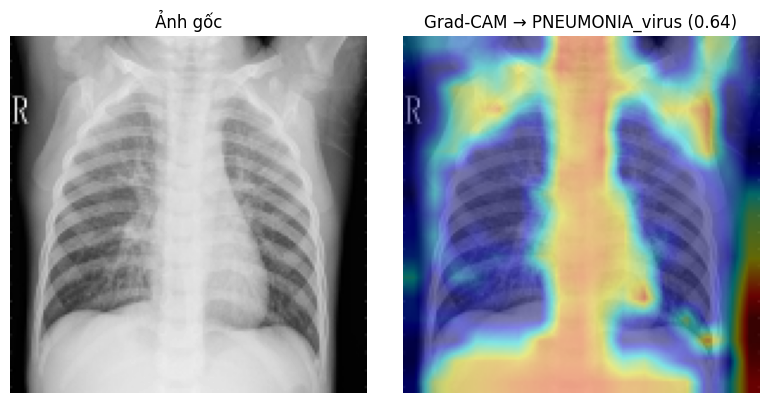

→ C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\NORMAL\Normal-10020.png


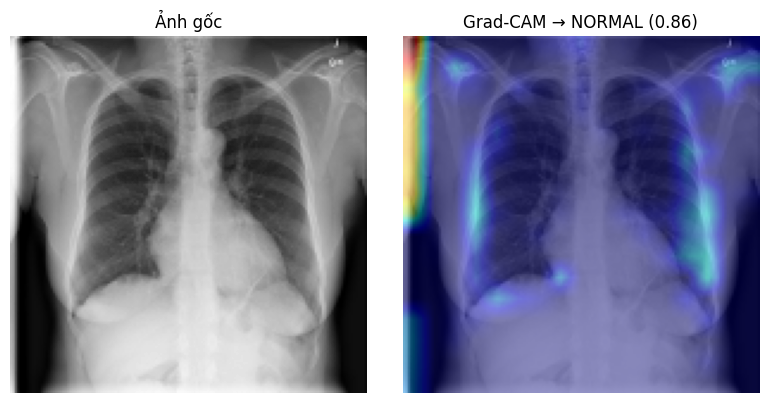

→ C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\test\PNEUMONIA_virus\Viral Pneumonia-678.png


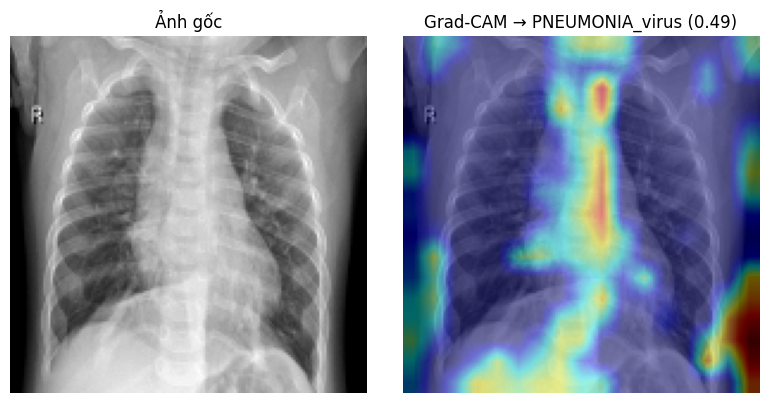

In [ ]:
# Lấy vài mẫu từ test/
sample_list = []
for c in CLASSES:
    sample_list += glob.glob(os.path.join(test_dir, c, "*"))
random.shuffle(sample_list)
# Vẽ Grad-CAM 3 ảnh
print("test 3 ảnh Grad-CAM:")
for fp in sample_list[:3]:
    print("→", fp)
    show_gradcam_pair(fp, model, IMG_SIZE)

# 8. Tạo ảnh hàng loạt và mục lưu Grad-CAM cho CNN_normal 


8.1 Khai báo đường dẫn đầu ra & tạo cây thư mục

In [ ]:
OUT_BASE = os.path.join(DATA_DIR, "outputs", "gradcam_cnn_normal")

# Tạo sẵn cây thư mục cho mỗi nhãn + correct/wrong
for cls in CLASSES:
    for sub in ["correct", "wrong"]:
        os.makedirs(os.path.join(OUT_BASE, cls, sub), exist_ok=True)

print("Cấu trúc đầu ra đã sẵn sàng tại:", OUT_BASE)

Cấu trúc đầu ra đã sẵn sàng tại: C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\gradcam_cnn_normal


8.2 Hàm tạo 2 panel (Ảnh gốc và Grad-CAM) và dự đoán

In [ ]:
import cv2, numpy as np, tensorflow as tf

def gradcam_panels_from_array(x01, target_size, model):
    preds = model.predict(x01, verbose=0)[0]
    pred_idx  = int(np.argmax(preds))
    pred_lbl  = CLASSES[pred_idx]
    pred_prob = float(preds[pred_idx])

    last_conv_name = pick_last_conv_layer(model)
    heatmap = make_gradcam_heatmap(x01, model, last_conv_name, class_index=pred_idx)

    # Heatmap màu
    heatmap = cv2.resize(heatmap, target_size)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # BGR

    # Ảnh gốc 1 kênh -> RGB
    img_gray = np.uint8(np.clip(x01[0] * 255.0, 0, 255))      # (H,W,1)
    left_rgb = np.repeat(img_gray, 3, axis=2)                 # RGB

    # Overlay (đưa left sang BGR để cộng rồi trả lại RGB)
    overlay_bgr = cv2.addWeighted(left_rgb[:, :, ::-1], 0.6, heatmap, 0.4, 0)
    right_rgb   = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    return left_rgb, right_rgb, pred_lbl, pred_prob

8.3 Hàm lưu figure có tiêu đề

In [27]:
import matplotlib.pyplot as plt
# font mặc định có hỗ trợ tiếng Việt tốt
plt.rcParams["font.family"] = "DejaVu Sans"

def save_panels_with_titles(left_rgb, right_rgb, save_path, pred_lbl, pred_prob):
    #Lưu ảnh 2 panel với tiêu đề: Trái : Ảnh gốc, Phải :Grad-CAM cho
    fig = plt.figure(figsize=(10, 3.6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(left_rgb)
    ax1.set_title("Ảnh gốc")
    ax1.axis("off")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(right_rgb)
    ax2.set_title(f"Grad-CAM cho {pred_lbl} ({pred_prob:.2f})")
    ax2.axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close(fig)

8.4 Quét toàn bộ ảnh trong test/

In [ ]:
all_test = []
for cls in CLASSES:
    for ext in ("*.jpg", "*.jpeg", "*.png", "*.bmp"):
        all_test += glob.glob(os.path.join(test_dir, cls, ext))
print(f"Tổng số ảnh test: {len(all_test)}")

Tổng số ảnh test: 1355


8.5 Vòng lặp xử lý & lưu (phân correct/wrong theo nhãn thật)

In [ ]:
import glob, os, re
def _safe_name(s: str):
    return re.sub(r"[^a-zA-Z0-9._-]+", "_", s)

saved = 0
for i, img_path in enumerate(all_test, 1):
    true_cls = os.path.basename(os.path.dirname(img_path))

    # Đọc ảnh grayscale, scale 0–1
    img0 = tf.keras.preprocessing.image.load_img(
        img_path, target_size=IMG_SIZE, color_mode="grayscale"
    )
    x = tf.keras.preprocessing.image.img_to_array(img0) / 255.0
    x = np.expand_dims(x, 0)

    # Lấy 2 panel + nhãn dự đoán
    left_rgb, right_rgb, pred_lbl, pred_prob = gradcam_panels_from_array(x, IMG_SIZE, model)

    # Phân vào correct/wrong theo nhãn thật
    sub = "correct" if pred_lbl == true_cls else "wrong"

    base = _safe_name(os.path.splitext(os.path.basename(img_path))[0])
    out_name = f"{base}__pred-{pred_lbl}_{pred_prob:.2f}__true-{true_cls}.jpg"
    out_path = os.path.join(OUT_BASE, true_cls, sub, out_name)
    # Lưu figure có tiêu đề như mẫu
    save_panels_with_titles(left_rgb, right_rgb, out_path, pred_lbl, pred_prob)
    saved += 1

    if i % 100 == 0 or i == len(all_test):
        print(f"Đã xử lý {i}/{len(all_test)} ảnh...")

print(f"\n Đã lưu {saved} ảnh vào: {OUT_BASE}")


Đã xử lý 100/1355 ảnh...
Đã xử lý 200/1355 ảnh...
Đã xử lý 300/1355 ảnh...
Đã xử lý 400/1355 ảnh...
Đã xử lý 500/1355 ảnh...
Đã xử lý 600/1355 ảnh...
Đã xử lý 700/1355 ảnh...
Đã xử lý 800/1355 ảnh...
Đã xử lý 900/1355 ảnh...
Đã xử lý 1000/1355 ảnh...
Đã xử lý 1100/1355 ảnh...
Đã xử lý 1200/1355 ảnh...
Đã xử lý 1300/1355 ảnh...
Đã xử lý 1355/1355 ảnh...

 Đã lưu 1355 ảnh vào: C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\gradcam_cnn_normal


In [42]:
import os, glob, math, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger

# Cell 9 Xác thực chéo

9.1 Gom đường dẫn & nhãn từ train/ + val/

In [41]:
import os, glob, pandas as pd

def collect_paths_labels(root_dir, classes):
    rows = []
    for cls in classes:
        for ext in ("*.jpg","*.jpeg","*.png","*.bmp"):
            for p in glob.glob(os.path.join(root_dir, cls, ext)):
                rows.append({"filepath": p, "label": cls})
    return rows

rows = []
rows += collect_paths_labels(train_dir, CLASSES)
rows += collect_paths_labels(val_dir,   CLASSES)

df_all = pd.DataFrame(rows)
print("Tổng ảnh dùng cho k-fold:", len(df_all))
df_all.head()

Tổng ảnh dùng cho k-fold: 10456


,filepath,label
0,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,NORMAL
1,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,NORMAL
2,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,NORMAL
3,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,NORMAL
4,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,NORMAL


9.2 Tạo DataFrame + mã hoá nhãn số cho stratify

In [43]:
df_all = pd.DataFrame(rows).sample(frac=1.0, random_state=42).reset_index(drop=True)
label2idx = {c:i for i,c in enumerate(CLASSES)}
y_idx_all = df_all["label"].map(label2idx).values
display(df_all.head())

,filepath,label
0,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,PNEUMONIA_virus
1,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,PNEUMONIA_bacteria
2,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,PNEUMONIA_bacteria
3,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,PNEUMONIA_bacteria
4,C:\Users\VACB\OneDrive\Desktop\xception_v2\che...,NORMAL


9.3 DataGenerators (augment cho train, plain cho val)

In [44]:
train_aug_cv = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8, width_shift_range=0.05, height_shift_range=0.05,
    zoom_range=0.05, shear_range=0.05, horizontal_flip=True, fill_mode="nearest"
)
plain_gen_cv = ImageDataGenerator(rescale=1./255)

9.4 Factory tạo generator từ DataFrame

In [45]:
def make_gen_from_df(df, gen, shuffle, batch=BATCH):
    return gen.flow_from_dataframe(
        df, x_col="filepath", y_col="label",
        classes=CLASSES, class_mode="categorical",
        target_size=IMG_SIZE, color_mode="grayscale",
        shuffle=shuffle, batch_size=batch, validate_filenames=False)

9.5 Khai báo KFold và thư mục log/ckpt

In [46]:
K = 3
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

CKPT_KFOLD_DIR = os.path.join(DATA_DIR, "outputs", "checkpoints_kfold"); os.makedirs(CKPT_KFOLD_DIR, exist_ok=True)
LOGS_KFOLD_DIR  = os.path.join(DATA_DIR, "outputs", "logs_kfold");        os.makedirs(LOGS_KFOLD_DIR, exist_ok=True)
print("KFold chạy được rồi", CKPT_KFOLD_DIR, "|", LOGS_KFOLD_DIR)

KFold chạy được rồi C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\checkpoints_kfold | C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\logs_kfold


9.6 Hàm build model CNN của tác giả, 3 lớp

In [47]:
def build_author_cnn(input_shape=(150,150,1), n_classes=3):
    m = models.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    m.compile(optimizer=optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return m

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

9.7 Factory callbacks theo từng fold


In [50]:
def make_callbacks_for_fold(fold_id):
    ckpt_path = os.path.join(CKPT_KFOLD_DIR, f"author_cnn_k3_fold{fold_id}.h5")
    log_csv   = os.path.join(LOGS_KFOLD_DIR,  f"history_fold{fold_id}.csv")
    return [
        ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
        CSVLogger(log_csv)]

9.8 Biến lưu kết quả của tất cả folds

In [52]:
fold_histories = []     
fold_scores    = []     

9.9 Vòng lặp train từng fold 

In [54]:
EPOCHS_CV = 20

for fold, (tr_idx, va_idx) in enumerate(skf.split(df_all["filepath"].values, y_idx_all), start=1):
    print(f"\nFOLD {fold}/{K}")
    df_tr = df_all.iloc[tr_idx].reset_index(drop=True)
    df_va = df_all.iloc[va_idx].reset_index(drop=True)

    gen_tr = make_gen_from_df(df_tr, train_aug_cv, shuffle=True,  batch=BATCH)
    gen_va = make_gen_from_df(df_va, plain_gen_cv, shuffle=False, batch=BATCH)

    steps_tr = max(1, math.ceil(len(df_tr)/BATCH))
    steps_va = max(1, math.ceil(len(df_va)/BATCH))

    model_k = build_author_cnn(IMG_SIZE + (1,), n_classes=len(CLASSES))
    callbacks = make_callbacks_for_fold(fold)

    hist = model_k.fit(
        gen_tr, epochs=EPOCHS_CV, steps_per_epoch=steps_tr,
        validation_data=gen_va, validation_steps=steps_va,
        callbacks=callbacks, verbose=1)
                                                                                                                                                                                                        
    val_loss, val_acc = model_k.evaluate(gen_va, steps=steps_va, verbose=0)
    print(f"[FOLD {fold}] val_acc={val_acc:.4f} | val_loss={val_loss:.4f}")

    fold_histories.append(hist.history)
    fold_scores.append({"fold": fold, "val_acc": float(val_acc), "val_loss": float(val_loss)})


FOLD 1/3
Found 6970 non-validated image filenames belonging to 3 classes.
Found 3486 non-validated image filenames belonging to 3 classes.
Epoch 1/20
218/218 [==============================] - ETA: 0s - loss: 0.7872 - accuracy: 0.6263
Epoch 1: val_accuracy improved from -inf to 0.75158, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\checkpoints_kfold\author_cnn_k3_fold1.h5
218/218 [==============================] - 229s 1s/step - loss: 0.7872 - accuracy: 0.6263 - val_loss: 0.5620 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 2/20
218/218 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7217
Epoch 2: val_accuracy improved from 0.75158 to 0.75301, saving model to C:\Users\VACB\OneDrive\Desktop\xception_v2\chest_xray_v2\outputs\checkpoints_kfold\author_cnn_k3_fold1.h5
218/218 [==============================] - 88s 404ms/step - loss: 0.6214 - accuracy: 0.7217 - val_loss: 0.5426 - val_accuracy: 0.7530 - lr: 0.0010
Epoch 3/20
218/218 [===

# 10. Đánh giá các Fold

10.1 Nạp tất cả checkpoint của 3 fold

In [63]:
import os, tensorflow as tf

fold_ckpts = []
for f in range(1, 3+1):
    p = os.path.join(CKPT_KFOLD_DIR, f"author_cnn_k3_fold{f}.h5")
    if os.path.isfile(p):
        fold_ckpts.append((f, p))
print("Found ckpts:", fold_ckpts)

Found ckpts: [(1, 'C:\\Users\\VACB\\OneDrive\\Desktop\\xception_v2\\chest_xray_v2\\outputs\\checkpoints_kfold\\author_cnn_k3_fold1.h5'), (2, 'C:\\Users\\VACB\\OneDrive\\Desktop\\xception_v2\\chest_xray_v2\\outputs\\checkpoints_kfold\\author_cnn_k3_fold2.h5'), (3, 'C:\\Users\\VACB\\OneDrive\\Desktop\\xception_v2\\chest_xray_v2\\outputs\\checkpoints_kfold\\author_cnn_k3_fold3.h5')]


10.2 Hàm tiện ích dự đoán (trả probability) cho 1 model

In [64]:
import numpy as np, math

def predict_probs_on_gen(model, gen, batch=BATCH):
    steps = math.ceil(gen.samples / batch)
    gen.reset()
    probs = model.predict(gen, steps=steps, verbose=0)
    return probs[:gen.samples]  # cắt vừa đúng số ảnh

10.3 Evaluate từng fold trên test/ (acc/loss) & lưu probs

In [66]:
fold_test_scores = []
fold_test_probs  = {}   

for fold_id, ckpt_path in fold_ckpts:
    m = tf.keras.models.load_model(ckpt_path)
    # loss/acc
    test_steps = math.ceil(test_gen.samples / BATCH)
    loss, acc = m.evaluate(test_gen, steps=test_steps, verbose=0)
    fold_test_scores.append({"fold": fold_id, "test_acc": float(acc), "test_loss": float(loss)})

    # probs
    probs = predict_probs_on_gen(m, test_gen, batch=BATCH)
    fold_test_probs[fold_id] = probs
    print(f"[Fold {fold_id}] test_acc={acc:.4f} | test_loss={loss:.4f}")

import pandas as pd
df_fold_test = pd.DataFrame(fold_test_scores).set_index("fold").sort_index()
display(df_fold_test)

[Fold 1] test_acc=0.7395 | test_loss=0.6859
[Fold 2] test_acc=0.7653 | test_loss=0.6637
[Fold 3] test_acc=0.7542 | test_loss=0.5799


,test_acc,test_loss
fold,,
1,0.739483,0.685932
2,0.765314,0.663717
3,0.754244,0.579873


9.10 Bảng tổng hợp + trung bình/độ lệch

Ensemble (mean probs) — Classification report
                    precision    recall  f1-score   support

            NORMAL     0.9584    0.7604    0.8480       455
PNEUMONIA_bacteria     0.7418    0.7533    0.7475       450
   PNEUMONIA_virus     0.6425    0.7667    0.6991       450

          accuracy                         0.7601      1355
         macro avg     0.7809    0.7601    0.7649      1355
      weighted avg     0.7816    0.7601    0.7652      1355



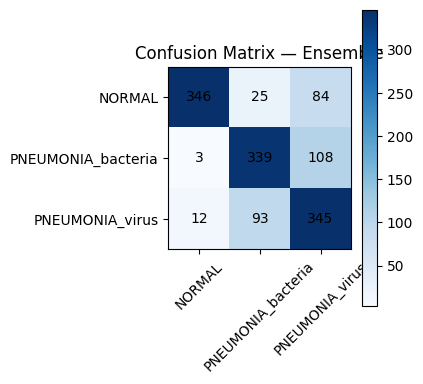

In [68]:
y_true = test_gen.classes
n_classes = len(CLASSES)

# tính trung bình probs trên các fold đã có
stack = np.stack([fold_test_probs[fid] for fid,_ in fold_ckpts], axis=0)  # (K, N, C)
probs_ens = stack.mean(axis=0)                                            # (N, C)
y_pred_ens = np.argmax(probs_ens, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print("Ensemble (mean probs) — Classification report")
print(classification_report(y_true, y_pred_ens, target_names=CLASSES, digits=4))

cm = confusion_matrix(y_true, y_pred_ens)
plt.figure(figsize=(4.2,4.2))
plt.imshow(cm, cmap="Blues"); plt.title("Confusion Matrix — Ensemble")
plt.xticks(range(n_classes), CLASSES, rotation=45); plt.yticks(range(n_classes), CLASSES)
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar(); plt.tight_layout(); plt.show()